In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import os
from PIL import Image
import json
from torchvision.transforms import ToTensor
import torchvision
from tqdm import tqdm

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        # 데이터셋의 루트 디렉터리 설정
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.transform = transform

        # 이미지 파일 리스트 가져오기
        self.image_files = sorted([f for f in tqdm(os.listdir(self.image_dir), desc="Loading Images") if f.endswith('.jpg')])

        # 레이블을 정수로 매핑
        self.label_map = {
            "car": 0,
            "truck": 1,
            "bus": 2,
            "special_vehicle": 3,
            "motorcycle": 4,
            "bicycle": 5,
            "pedestrian": 6,
            "traffic_sign": 7,
            "traffic_light": 8,
            "none": 9
        }

    def __len__(self):
        # 데이터셋의 총 길이 반환
        return len(self.image_files)

    def __getitem__(self, idx):
        # 이미지와 레이블 경로 가져오기
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = img_path.replace("images", "labels").replace(".jpg", ".json")

        # 이미지 로드 및 텐서로 변환
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        else:
            image = ToTensor()(image)

        # 레이블 데이터 로드
        with open(label_path, 'r') as file:
            label_data = json.load(file)
        boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
        labels = [anno['Label'] for anno in label_data['Annotation']]

        # 문자열 레이블을 정수로 변환
        labels = [self.label_map[label] for label in labels]

        # 타겟 데이터 생성
        target = {}
        converted_boxes = [[box[0], box[1], box[0]+box[2], box[1]+box[3]] for box in boxes]
        target["boxes"] = torch.tensor(converted_boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        return image, target


In [ ]:
# 데이터 로더 생성
from torch.utils.data import DataLoader

train_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/training")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

val_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/validation")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

test_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/test")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))


Loading Images: 100%|██████████| 100/100 [00:00<00:00, 540503.09it/s]


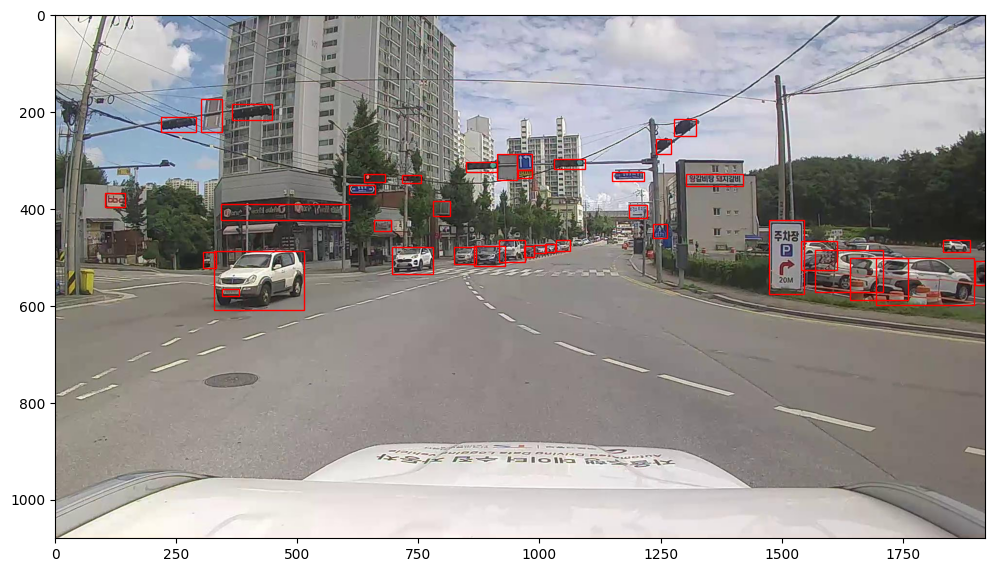

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_first_image(dataset):
    image, target = dataset[0]

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image.permute(1, 2, 0).numpy())

    for box in target["boxes"]:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

show_first_image(train_dataset)

In [ ]:
# 데이터셋에서 첫 번째 아이템 가져오기
image, target = train_dataset[0]

print(f"Image shape: {image.shape}")
print(f"Target boxes: {target['boxes']}")
print(f"Target labels: {target['labels']}")

Image shape: torch.Size([3, 1080, 1920])
Target boxes: tensor([[ 304.9500,  487.4900,  332.1000,  521.4100],
        [1640.9200,  500.3600, 1760.6200,  587.4400],
        [ 658.5400,  422.7100,  693.4900,  446.0100],
        [ 345.4500,  565.0200,  379.0000,  580.1200],
        [1568.1400,  484.7700, 1709.9399,  571.8400],
        [1540.8500,  466.5700, 1615.0601,  526.3500],
        [1695.5100,  500.3600, 1897.0800,  597.8300],
        [ 102.9600,  366.9400,  145.0600,  395.0600],
        [ 343.4000,  389.9600,  607.6000,  421.8700],
        [ 848.9700,  301.7500,  913.1000,  323.7000],
        [1029.0500,  297.1400, 1093.6000,  316.4000],
        [ 605.7700,  350.3800,  660.9000,  369.5000],
        [ 954.0300,  285.4800,  983.7500,  319.6800],
        [1149.8400,  322.6700, 1215.1000,  342.2000],
        [1233.7600,  431.4800, 1262.5000,  460.3000],
        [1472.9301,  421.6700, 1546.6000,  575.7000],
        [ 780.6300,  383.3100,  815.8000,  413.8000],
        [1301.8800,  326.85

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch.nn as nn

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 아래는 추가적인 레이어를 포함하는 분류기를 만드는 예제입니다.
    # 주석 처리된 부분을 활성화시키고 원래의 FastRCNNPredictor 코드를 주석 처리하여 사용할 수 있습니다.
    """
    classifier = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features,
        num_classes,
        classifier=classifier
    )
    """

    # 원래의 레이어 구조 사용
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

model = get_model(num_classes=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 81.3MB/s]


In [ ]:
import torch
from torch.optim import SGD

# 디바이스 설정 (GPU가 사용 가능하면 GPU를, 그렇지 않으면 CPU를 사용)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 최적화를 위한 파라미터 설정 (requires_grad가 True인 경우만)
params = [p for p in model.parameters() if p.requires_grad]
# 학습률을 일반적으로 사용되는 0.001로 설정
optimizer = SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

num_epochs = 10

model.train()

# 조기 종료를 위한 설정
patience = 3
no_improve = 0
best_loss = float('inf')

for epoch in range(num_epochs):
    total_loss = 0.0
    # 학습 데이터를 통한 학습
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()  # 최적화 변수의 기울기 초기화
        loss_dict = model(images, targets)  # 손실 계산
        losses = sum(loss for loss in loss_dict.values())  # 총 손실

        losses.backward()  # 기울기 계산
        optimizer.step()  # 파라미터 업데이트

        total_loss += losses.item()

    epoch_loss = total_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # 조기 종료 로직
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        no_improve = 0
    else:
        no_improve += 1

    # 일정 에폭 동안 개선되지 않으면 학습 종료
    if no_improve == patience:
        print("조기 종료!")
        break

Epoch 1/10, Loss: 1.0207


Epoch 2/10, Loss: 0.7947


Epoch 3/10, Loss: 0.7088


Epoch 4/10, Loss: 0.6598


Epoch 5/10, Loss: 0.6193


Epoch 6/10, Loss: 0.5892


Epoch 7/10, Loss: 0.5618


Epoch 8/10, Loss: 0.5368


Epoch 9/10, Loss: 0.5104


Epoch 10/10, Loss: 0.4899


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for index, output in enumerate(outputs):
            pred_labels = output['labels']  # 예측된 라벨 전체
            true_labels = targets[index]['labels']

            # 예측된 라벨과 실제 라벨의 개수를 동일하게 조정
            k = min(len(pred_labels), len(true_labels))
            pred_labels = pred_labels[:k]
            true_labels = true_labels[:k]

            correct += (pred_labels == true_labels).sum().item()
            total += len(true_labels)

accuracy = 100 * correct / total
print(f"Accuracy on validation set: {accuracy:.2f}%")

Accuracy on validation set: 18.81%


In [ ]:
import numpy as np
from tqdm import tqdm

def xywh_to_xyxy(boxes):
    """
    [x_min, y_min, width, height] 형식을 [x_min, y_min, x_max, y_max] 형식으로 변환합니다.

    Args:
        boxes: 변환하기 전의 bounding boxes

    Returns:
        변환된 bounding boxes
    """
    if len(boxes) == 0:
        return boxes
    return np.hstack((boxes[:, :2], boxes[:, :2] + boxes[:, 2:] - 1))

def box_iou(boxes1, boxes2):
    """
    두 세트의 박스 사이의 IoU (Intersection over Union)를 계산합니다.
    IoU는 두 영역의 교차 영역을 합집합 영역으로 나눈 값으로, 두 영역이 얼마나 잘 겹치는지를 나타냅니다.

    Args:
        boxes1: (N, 4) 형상의 bounding boxes
        boxes2: (M, 4) 형상의 bounding boxes

    Returns:
        (N, M) 형상의 IoU 배열
    """
    # 박스 좌표 분리
    x11, y11, w1, h1 = np.split(boxes1, 4, axis=1)
    x21, y21, w2, h2 = np.split(boxes2, 4, axis=1)

    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    # 교차 영역의 좌표 계산
    xi1 = np.maximum(x11, np.transpose(x21))
    yi1 = np.maximum(y11, np.transpose(y21))
    xi2 = np.minimum(x12, np.transpose(x22))
    yi2 = np.minimum(y12, np.transpose(y22))

    # 교차 영역의 넓이 계산
    inter_area = np.maximum(0, xi2 - xi1 + 1) * np.maximum(0, yi2 - yi1 + 1)

    # 각 박스의 넓이 계산
    boxes1_area = (w1 + 1) * (h1 + 1)
    boxes2_area = (w2 + 1) * (h2 + 1)

    # IoU 계산
    iou = inter_area / (boxes1_area + np.transpose(boxes2_area) - inter_area)

    return iou

def calculate_AP(det_boxes, det_scores, true_boxes, true_labels, class_idx):
    """
    주어진 클래스에 대한 AP (Average Precision)를 계산합니다.
    AP는 Precision과 Recall의 곱으로, 모델의 성능을 평가하는 척도 중 하나입니다.

    Args:
        det_boxes: 예측된 bounding boxes
        det_scores: 예측된 bounding boxes의 점수
        true_boxes: 실제 bounding boxes
        true_labels: 실제 라벨
        class_idx: 평가할 클래스의 인덱스

    Returns:
        해당 클래스에 대한 AP 값
    """
    det_mask = (det_scores > 0.5)
    true_mask = true_labels == class_idx

    det_boxes = det_boxes[det_mask]
    true_boxes = true_boxes[true_mask]

    if len(det_boxes) == 0 or len(true_boxes) == 0:
        return 0.0

    ious = box_iou(det_boxes, true_boxes)
    max_ious = np.max(ious, axis=1)
    detected_mask = max_ious >= 0.5

    tp = np.sum(detected_mask)
    fp = len(det_boxes) - tp
    fn = len(true_boxes) - tp

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    return precision * recall

def calculate_mAP(model, data_loader, device, num_classes=10):
    """
    모델의 mAP (mean Average Precision)를 계산합니다.
    mAP는 모든 클래스에 대한 AP의 평균값으로, 전체 모델의 성능을 나타내는 척도입니다.

    Args:
        model: 평가할 모델
        data_loader: 데이터 로더
        device: 모델과 데이터를 실행할 장치 (예: 'cuda')
        num_classes: 전체 클래스 수

    Returns:
        mAP: 0과 100 사이의 값. 100이면 완벽한 예측, 0이면 모든 예측이 틀렸음을 의미합니다.
    """
    det_boxes = []
    det_scores = []
    true_boxes = []
    true_labels = []

    for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
        images = [img.to(device) for img in images]
        predictions = model(images)

        for i, prediction in enumerate(predictions):
            det_boxes.extend(prediction['boxes'].detach().cpu().numpy())
            det_scores.extend(prediction['scores'].detach().cpu().numpy())
            true_boxes.extend(targets[i]['boxes'].detach().cpu().numpy())
            true_labels.extend(targets[i]['labels'].detach().cpu().numpy())

    APs = []
    for class_idx in range(num_classes):
        AP = calculate_AP(np.array(det_boxes), np.array(det_scores), np.array(true_boxes), np.array(true_labels), class_idx)
        APs.append(AP)

    return np.mean(APs)

mAP = calculate_mAP(model, val_loader, device)
print(f"mAP: {mAP:.4f}")

mAP: 7.1538
